# Papers:

https://www.semanticscholar.org/paper/Analysis-of-focus-measure-operators-for-Pertuz-Puig/8c675bf5b542b98bf81dcf70bd869ab52ab8aae9?p2df
https://pyimagesearch.com/2020/06/15/opencv-fast-fourier-transform-fft-for-blur-detection-in-images-and-video-streams/

### Import modules and image loading

In [2]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load an image from the 'images' folder
image_path = os.path.join('images', 'tiger.jpeg')

# Read the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

## FTT: Fast fourier transformation

The fast Fourier transform (FFT) is an algorithm that computes the discrete Fourier transform (DFT) of a sequence. In our case we are dealing with a 2D signal, the image. In this process our signal in the space domain is transformed to its representation in the frequency domain.

Since images are always represented in the discrete domain we cannot use the original Fourier Transform but we have to use instead the Discrete Fourier Transform (DFT).

- **Fourier Transform**:

  $ F(u, v) = \iint_{-\infty}^{\infty} f(x, y) e^{-j2\pi(ux + vy)} \, dx \, dy $

- **Discrete Fourier Transform**:

  $ F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) e^{-j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)} $


For calculating the FFT we can simply use the function `cv2.dft()`.

Shape of the result: (194, 259)


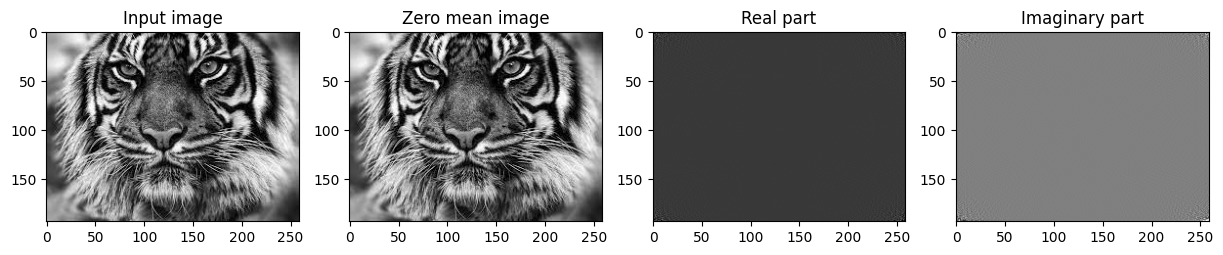

In [3]:
# use the zero mean image to remove the DC component
image_zero_mean = image - np.mean(image)

ftt = np.fft.fft2(image_zero_mean)
print(f"Shape of the result: {ftt.shape}")

# plot real and imaginary parts of the image
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(image, cmap='gray')
plt.title('Input image')
plt.subplot(142)
plt.imshow(image_zero_mean, cmap='gray')
plt.title('Zero mean image')
plt.subplot(143)
plt.imshow(np.real(ftt), cmap='gray')
plt.title('Real part')
plt.subplot(144)
plt.imshow(np.imag(ftt), cmap='gray')
plt.title('Imaginary part')
plt.show()

### Shift the zero-frequency component to the center of the spectrum

The zero-frequency component is located at the top-left corner of the FFT image. We can shift it to the center of the image by using the function `np.fft.fftshift()`. This is to make the FFT image more clear and easier to analyze.

To do that we can use the function `np.fft.fftshift()`.

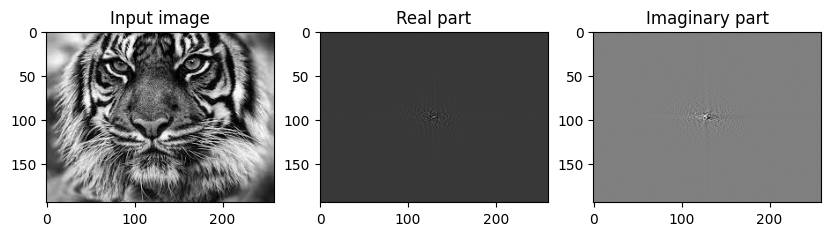

In [4]:
ftts = np.fft.fftshift(ftt)

# plot real and imaginary parts of the image
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Input image')
plt.subplot(132)
plt.imshow(np.real(ftts), cmap='gray')
plt.title('Real part')
plt.subplot(133)
plt.imshow(np.imag(ftts), cmap='gray')
plt.title('Imaginary part')
plt.show()


# Magnitude calculation

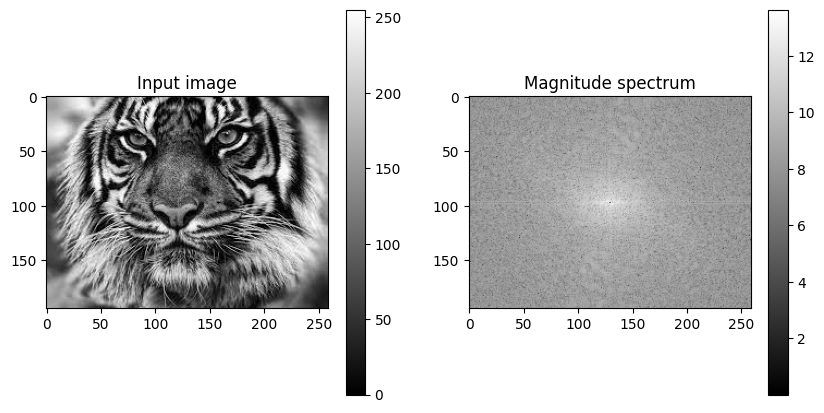

In [5]:
magnitude_spectrum = np.abs(ftts)

epsilon = 1.0001

# plot real and imaginary parts of the image
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Input image')
plt.subplot(122)
magnitude_visualization = np.log(epsilon + magnitude_spectrum)
plt.imshow(magnitude_visualization, cmap='gray')
plt.colorbar()
plt.title('Magnitude spectrum')
plt.show()


## Removing low frequencies

- Blurred images generally lack sharp edges and fine details, which correspond to high-frequency components in the frequency domain. When an image is blurred, the high-frequency components are attenuated.

- Details and edges in images are represented by high-frequency components. By analyzing these components, you can assess the presence and strength of edges and textures


Apply a high pass filter to the FFT image to remove the low frequencies.
This is done by masking the low frequencies with a rectangular window of size proportional to the size of the image.


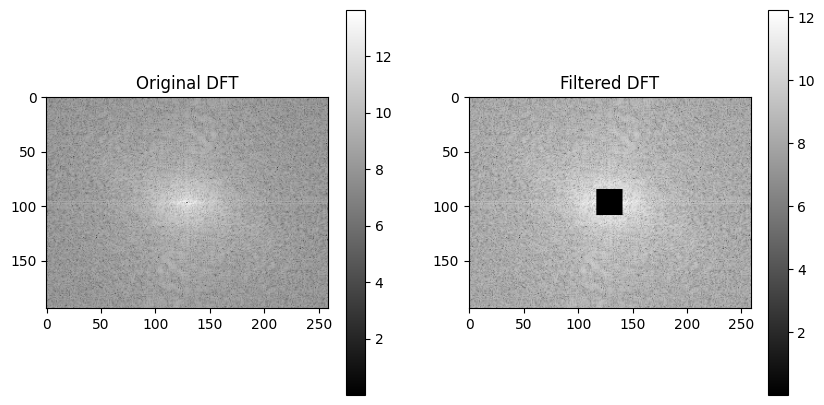

In [6]:
# create a mask first, center square is 1, remaining all zeros
rows, cols = image.shape

# 10% of the rows and cols
size = int(max([rows, cols]) * 0.05)
high_pass_mask = np.ones(image.shape)
high_pass_mask[
    rows // 2 - size : rows // 2 + size,
    cols // 2 - size : cols // 2 + size
] = 0

# apply the mask to the fft obtained in the previous section and display the results
filtered_ftts = ftts * high_pass_mask
filtered_magnitude = np.abs(filtered_ftts)

# plot filtered and unfiltered images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(magnitude_visualization, cmap='gray')
plt.title('Original DFT')
plt.colorbar()
plt.subplot(122)
magnitude_visualization_filtered = np.log(epsilon + filtered_magnitude)
plt.imshow(magnitude_visualization_filtered, cmap='gray')
plt.title('Filtered DFT')
plt.colorbar()
plt.show()

# Calculate the inverse FFT

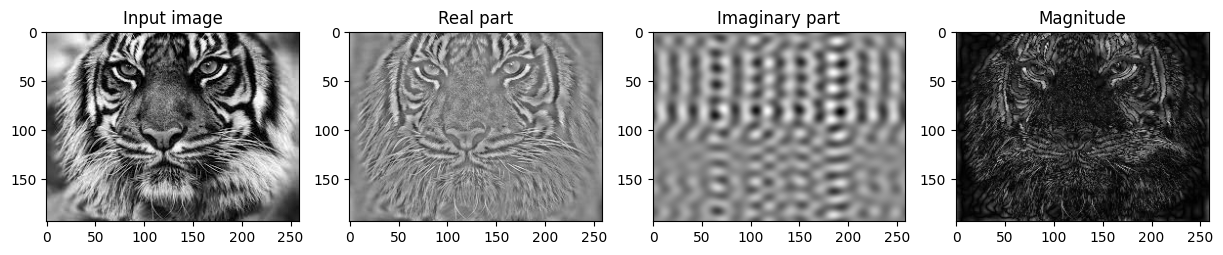

In [7]:
iftts = np.fft.ifftshift(filtered_ftts)
iftt = np.fft.ifft2(iftts)

# plot real and imaginary parts of the image
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(image, cmap='gray')
plt.title('Input image')
plt.subplot(142)
plt.imshow(np.real(iftt), cmap='gray')
plt.title('Real part')
plt.subplot(143)
plt.imshow(np.imag(iftt), cmap='gray')
plt.title('Imaginary part')
plt.subplot(144)
plt.imshow(np.abs(iftt), cmap='gray')
plt.title('Magnitude')
plt.show()

## Determine blur

In [19]:
magnitude = np.abs(iftt)
mean = np.mean(magnitude)
    
# Determine if the image is blurry
blurry = mean < 8

print("Blur score: ", mean)

if blurry:
    print('The image is blurry')
else:
    print('The image is not blurry')

Blur score:  33.2456861986489
The image is not blurry


## Blur detection with webcam

In [17]:
def get_blur_score(image, treshold=8):
    # check if the image is grayscale, and convert it back to grayscale if necessary
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # use the zero mean image to remove the DC component
    image_zero_mean = image - np.mean(image)

    # compute the fft of the image
    ftt = np.fft.fft2(image_zero_mean)
    ftts = np.fft.fftshift(ftt)

    # remove central frequencies
    rows, cols = image.shape
    size = int(max([rows, cols]) * 0.05)
    high_pass_mask = np.ones(image.shape)
    high_pass_mask[
        rows // 2 - size : rows // 2 + size,
        cols // 2 - size : cols // 2 + size
    ] = 0

    # apply the mask to the fft obtained in the previous section and display the results
    filtered_ftts = ftts * high_pass_mask

    # compute the inverse fft
    iftts = np.fft.ifftshift(filtered_ftts)
    iftt = np.fft.ifft2(iftts)

    # compute the magnitude
    magnitude = np.abs(iftt)

    mean = np.mean(magnitude)

    # compute the mean of the magnitude
    return mean, mean < treshold


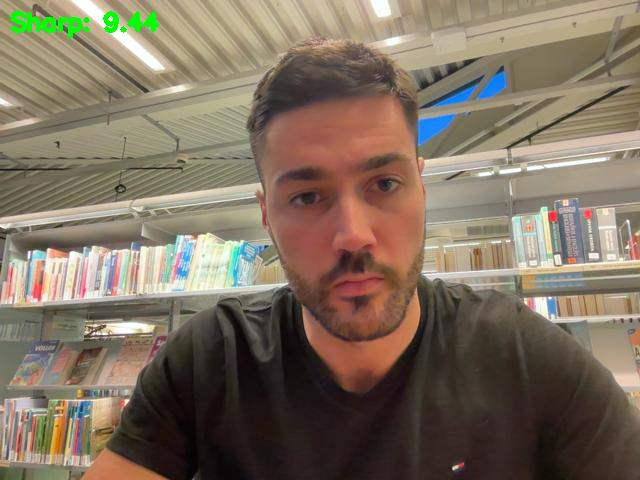

In [18]:
from IPython.display import display, clear_output
import io
from PIL import Image

# Open the webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    raise IOError("Cannot open webcam")

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Detect blur in the current frame
        mean_magnitude, blurry = get_blur_score(frame)
        
        # Prepare the label for the frame
        text = 'Blurry' if blurry else 'Sharp'
        color = (0, 0, 255) if blurry else (0, 255, 0)
        
        # Put the label on the frame
        cv2.putText(frame, '{}: {:.2f}'.format(text, mean_magnitude), (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = Image.fromarray(frame)

        # Convert to JPEG to reduce transfer size over the network
        with io.BytesIO() as f:
            im.save(f, format='JPEG')
            # Display the image
            display(Image.open(f))

        # Clear the output after displaying the frame
        clear_output(wait=True)
except KeyboardInterrupt:
    # When everything done, release the capture on interrupt
    cap.release()
    # print("Stream stopped")